In [1]:
library(raster)
library(ggmap)
library(spdep)
library(tmap)
library(rgdal)
library(classInt)
library(RColorBrewer)

Loading required package: sp
Loading required package: ggplot2
Loading required package: Matrix
Warning message:
“package ‘tmap’ was built under R version 3.4.3”rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/GDAL.framework/Versions/2.1/Resources/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.1, 04 March 2015, [PJ_VERSION: 491]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/sf/proj
 Linking to sp version: 1.2-5 


In [2]:
s1 <- readOGR("data/akCity_CAU01_ethnic.shp")

OGR data source with driver: ESRI Shapefile 
Source: "data/akCity_CAU01_ethnic.shp", layer: "akCity_CAU01_ethnic"
with 101 features
It has 14 fields
Integer64 fields read as strings:  POLY_ID SUM_EUROPE SUM_MAORI SUM_PACIFI SUM_ASIAN SUM_OTHER SUM_TOTAL 


In [3]:
summary(s1)
#Let's see a summary of our spatial data

Object of class SpatialPolygonsDataFrame
Coordinates:
      min     max
x 2658430 2679068
y 6469654 6483715
Is projected: TRUE 
proj4string :
[+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150
+datum=nzgd49 +units=m +no_defs +ellps=intl
+towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993]
Data attributes:
    POLY_ID       CAU_ID                   FIRST_CAU_   SUM_EUROPE   SUM_MAORI 
 1      : 1   514000 : 1   Abbotts Park         : 1   1837   : 2   113    : 3  
 10     : 1   514101 : 1   Akarana              : 1   1096   : 1   160    : 3  
 100    : 1   514102 : 1   Arch Hill            : 1   1128   : 1   65     : 3  
 101    : 1   514103 : 1   Auckland Central East: 1   1129   : 1   306    : 2  
 11     : 1   514200 : 1   Auckland Central West: 1   1135   : 1   310    : 2  
 12     : 1   514301 : 1   Auckland Harbourside : 1   1157   : 1   74     : 2  
 (Other):95   (Other):95   (Other)              :95   (Other):94   (Other):86  
   SUM_PACIFI   SUM_ASIAN    SUM_OTHER    SU

In [4]:
names(s1)
#names -> gives you the header (first row) of your data

[1] "POLY_ID"    "CAU_ID"     "FIRST_CAU_" "SUM_EUROPE" "SUM_MAORI" 
 [6] "SUM_PACIFI" "SUM_ASIAN"  "SUM_OTHER"  "SUM_TOTAL"  "PC_EUROPEA"
[11] "PC_MAORI"   "PC_PACIFIC" "PC_ASIAN"   "PC_OTHER"

In [5]:
data.frame(s1)
#The data frame -> row and header of data

,POLY_ID,CAU_ID,FIRST_CAU_,SUM_EUROPE,SUM_MAORI,SUM_PACIFI,SUM_ASIAN,SUM_OTHER,SUM_TOTAL,PC_EUROPEA,PC_MAORI,PC_PACIFIC,PC_ASIAN,PC_OTHER
0,1,514000,Freemans Bay,3002,339,262,182,289,4074,73.7,8.3,6.4,4.5,7.1
1,2,514101,Auckland Harbourside,995,49,42,310,173,1569,63.4,3.1,2.7,19.8,11.0
2,3,514102,Auckland Central West,1587,180,89,1062,489,3407,46.6,5.3,2.6,31.2,14.4
3,4,514103,Auckland Central East,1595,159,79,1309,526,3668,43.5,4.3,2.2,35.7,14.3
4,5,514200,Newton,529,65,28,131,118,871,60.7,7.5,3.2,15.0,13.5
5,6,514301,Grafton West,536,65,37,351,89,1078,49.7,6.0,3.4,32.6,8.3
6,7,514302,Grafton East,479,79,81,313,106,1058,45.3,7.5,7.7,29.6,10.0
7,8,514401,Roberton,2418,479,763,821,448,4929,49.1,9.7,15.5,16.7,9.1
8,9,514402,Glenavon,2039,536,1326,1311,407,5619,36.3,9.5,23.6,23.3,7.2
9,10,514500,New Windsor,2991,338,599,1835,382,6145,48.7,5.5,9.7,29.9,6.2


## Plotting the data on a map

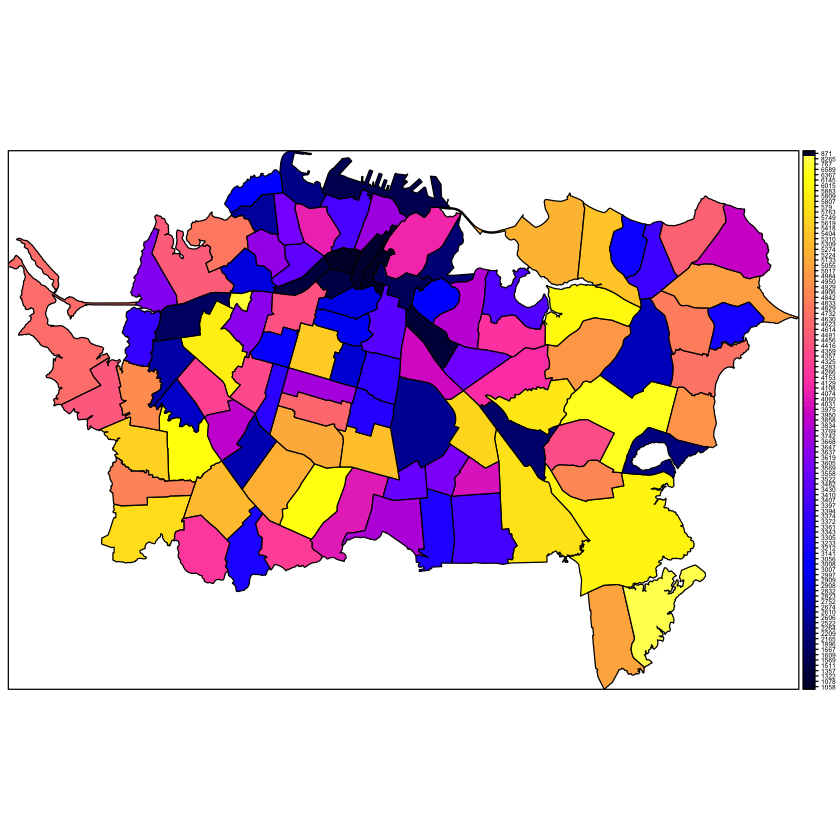

In [6]:
# Test plot the counties by `SUM_TOTAL` Column

spplot(s1, z="SUM_TOTAL", par.settings=list(fontsize=list(text=5)))

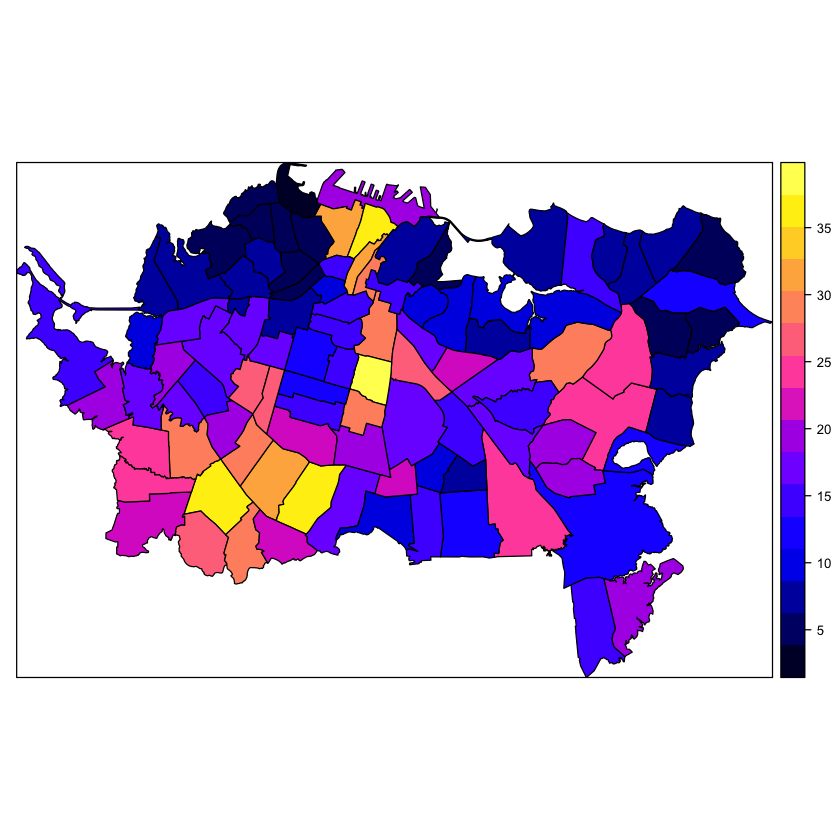

In [7]:
# Test plot the counties by `SUM_TOTAL` Column

spplot(s1, z="PC_ASIAN", par.settings=list(fontsize=list(text=10)))

## Equal Intervals Map

In [8]:
#First, let's make breaks in the data by using classIntervals()
#See https://www.rdocumentation.org/packages/classInt/versions/0.1-24/topics/classIntervals for
#Documentation of all options above
brks <-  classIntervals(s1$PC_ASIAN, n = 7, style = "equal")$brks
brks[length(brks)] <- brks[length(brks)] + 1

In [9]:
# Custom colors using brewer
pal  <- brewer.pal(7, "Blues")

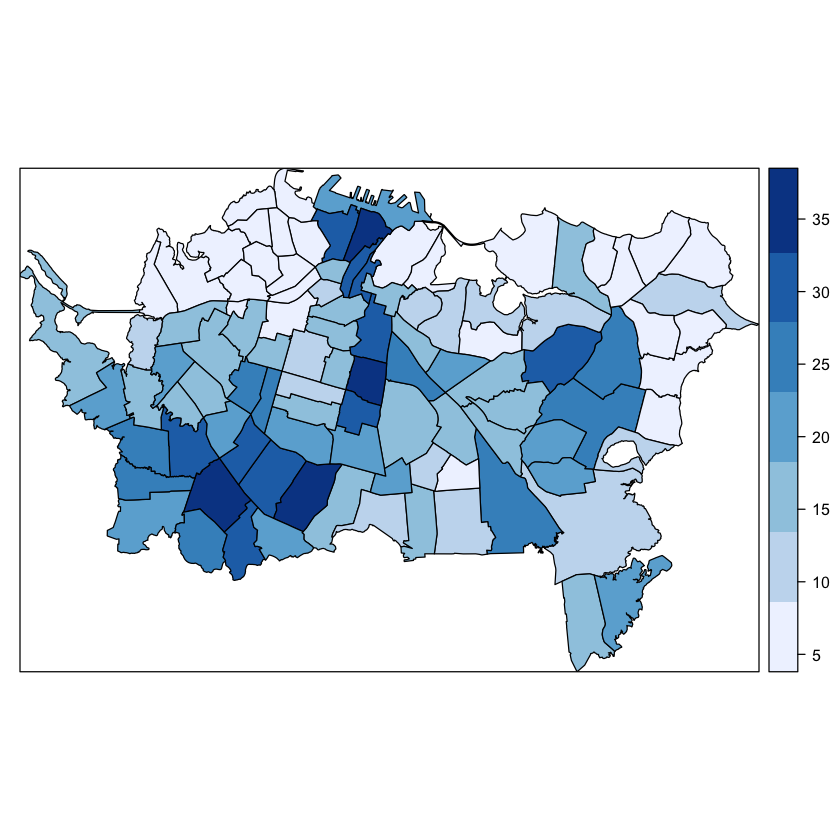

In [10]:

# Generate the map
spplot(s1, z="PC_ASIAN", at = brks, col.regions=pal)

In [11]:
# Shortcut using tmap

In [ ]:
qtm(s1, fill="PC_ASIAN", fill.style="equal", 
    fill.n=7 ,fill.palette="Greens")

## Standard Deviations Map